# Prueba

## Preparación del Notebook

### Importación de Librerías

In [1]:
# data analysis and wrangling
import pandas as pd
#import numpy as np
#import random as rnd
import opendatasets as od

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import models, layers, optimizers, regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
#from sklearn.svm import SVC, LinearSVC
#from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import Perceptron
#from sklearn.linear_model import SGDClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import cross_val_score, GridSearchCV
#from sklearn.metrics import accuracy_scor

### Descarga de Datasets desde Kaggle

In [2]:
od.download("https://www.kaggle.com/c/titanic/data")
{"username":"dgrone","key":"8e16739c70ce24ea1e6d9a45b61e9796"}

Skipping, found downloaded files in ".\titanic" (use force=True to force download)


{'username': 'dgrone', 'key': '8e16739c70ce24ea1e6d9a45b61e9796'}

### Carga de Datasets

In [3]:
#train_folder = "c:/Users/pablo/OneDrive/Documentos/GitHub/MDS-Notebooks/03-MLA/titanic/train.csv"
train_folder = "titanic/train.csv"
train_df = pd.read_csv(train_folder)

In [4]:
#test_folder = "c:/Users/pablo/OneDrive/Documentos/GitHub/MDS-Notebooks/03-MLA/titanic/test.csv"
test_folder = "titanic/test.csv"
test_df = pd.read_csv(test_folder)

## 1.- Limpieza de Datos

### 1.1.- Dataset de Entrenamiento

##### Dataset de Entrenamiento Original

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Información de Variables

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 1.2.- Primera Limpieza de Datos 

##### Renombramos Pclass por TicketClass
Esto se realiza para tener un nombre mas representativo

In [7]:
train_df = train_df.rename(columns = {'Pclass' : 'TicketClass'})

##### Análisis de Variable "Ticket"
En la información de la variable se aprecia que es del tipo objeto y en el Dataframe es posible apreciar que posee diferentes valores, por lo cual el número de ticket podría no ser representativo para el análisis

In [8]:
len(train_df['Ticket'].unique())

681

##### Codificación de Edad
Se reemplazan los valores nulos de edad por la media y se agrupan las edades en 2 grupos. Para menores de 14 años como niños y para mayores de 14 años como no-niños

In [9]:
median_age = train_df['Age'].median()
train_df['Age'].fillna(median_age, inplace=True)
train_df['Age']=train_df['Age'].astype(int)

bins = [ 0, 14, 26, 50, 100] 
age_index = (1,2,3,4) #(niños, jovenes, adultos, ancianos)
train_df['Age-bin'] = pd.cut(train_df.Age, bins, labels=age_index)

train_df[['Age-bin', 'Survived']].groupby(['Age-bin'],as_index=False).mean()

In [10]:
bins = [ 0, 14, 100] 
age_index = (0,1) #(niños, no-niños)
train_df['Age-bin'] = pd.cut(train_df.Age, bins, labels=age_index)

train_df[['Age-bin', 'Survived']].groupby(['Age-bin'],as_index=False).mean()

,Age-bin,Survived
0,0,0.535211
1,1,0.365314


##### Categorización de Embarque
Se completan los datos nulos conaquel que presenta mayor número de repeticiones (moda) y luegos se reemplaza la columna de "Embarqued" por 3 columnas, una para cada categoría de embarque (Q,C y S).

In [11]:
embarked_mode = train_df['Embarked'].mode()
train_df['Embarked'].fillna(embarked_mode.values[0], inplace=True)

In [12]:
Embarked_dum = pd.get_dummies(train_df['Embarked'], prefix = "embarked")
train_df = pd.concat([train_df, Embarked_dum], axis = 1)

##### Categorización de las Tarifas
Mediante el gráfico de distribución de la supervivencia respecto a las tarifas pagadas, es posible apreciar que gran parte de la mortandad se centra en las tarifas más pequeñas.

<AxesSubplot:xlabel='Fare', ylabel='Count'>

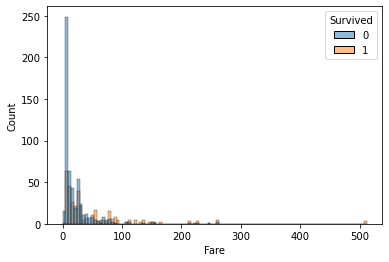

In [13]:
sns.histplot(x='Fare', data=train_df, hue='Survived')

In [14]:
median_fare = train_df['Fare'].median()
train_df['Fare'].fillna(median_fare, inplace=True)

In [15]:
train_df['Fare_cat'] = pd.cut(train_df['Fare'], bins=[-1, 35, float('Inf')], labels=['cheap', 'expensive'])
Fare_dum = pd.get_dummies(train_df['Fare_cat'], prefix = "fare")
train_df = pd.concat([train_df, Fare_dum], axis = 1)

##### Eliminación de Variables
Se eliminan las variabres que no contribuyen al análisis:
- Nombre: No proporciona información referente a la supervivencia de un pasajero
- Ticket: Posee 681 valores diferentes, lo que no aporta en identificar la supervivencia
- Cabina: Posee valor solo en 204 de 891 individuos equivalente a aproximadamente un 23%, por lo cual no es recomendable reemplazar los valores

In [16]:
train_df = train_df.drop(['Name','Ticket','Fare','Age','Cabin','Embarked','Fare_cat'],axis =1)

In [17]:
train_df.head()

,PassengerId,Survived,TicketClass,Sex,SibSp,Parch,Age-bin,embarked_C,embarked_Q,embarked_S,fare_cheap,fare_expensive
0,1,0,3,male,1,0,1,0,0,1,1,0
1,2,1,1,female,1,0,1,1,0,0,0,1
2,3,1,3,female,0,0,1,0,0,1,1,0
3,4,1,1,female,1,0,1,0,0,1,0,1
4,5,0,3,male,0,0,1,0,0,1,1,0


##### Etiquetación de Variables
En este caso se modifica el tipo de la variable "Sexo" de tipo "objeto" a etiquetas codificadas en forma "numérica".

In [18]:
label_encoder_sex = LabelEncoder()
train_df.iloc[:,3]  = label_encoder_sex.fit_transform(train_df.iloc[:,3])

In [19]:
train_df.head()

,PassengerId,Survived,TicketClass,Sex,SibSp,Parch,Age-bin,embarked_C,embarked_Q,embarked_S,fare_cheap,fare_expensive
0,1,0,3,1,1,0,1,0,0,1,1,0
1,2,1,1,0,1,0,1,1,0,0,0,1
2,3,1,3,0,0,0,1,0,0,1,1,0
3,4,1,1,0,1,0,1,0,0,1,0,1
4,5,0,3,1,0,0,1,0,0,1,1,0


##### Reordenamiento de Dataframe 
Se realiza un ordenamiento que busca dejar la variable objetivo al final, a fin de posteriormente separarlo de los datos a ingresar en el modelo de red neuronal.

In [20]:
train_df = train_df[['PassengerId','Sex', 'Age-bin','SibSp','Parch','TicketClass','embarked_C','embarked_Q','embarked_S','fare_cheap','fare_expensive','Survived']]
train_df.head()

,PassengerId,Sex,Age-bin,SibSp,Parch,TicketClass,embarked_C,embarked_Q,embarked_S,fare_cheap,fare_expensive,Survived
0,1,1,1,1,0,3,0,0,1,1,0,0
1,2,0,1,1,0,1,1,0,0,0,1,1
2,3,0,1,0,0,3,0,0,1,1,0,1
3,4,0,1,1,0,1,0,0,1,0,1,1
4,5,1,1,0,0,3,0,0,1,1,0,0


## 2.- Entrenamiento de Modelo


### 2.1.- Datasets de Entrenamiento y Validación

##### Dataframe de Datos

In [21]:
train_data = train_df.iloc[:,0:len(train_df.columns)-1] 

##### Dataframe de Variable Objetivo

In [22]:
train_target = train_df.iloc[:,len(train_df.columns)-1]  

##### Lista de Características de los Datos

In [23]:
features = train_data.columns.values
features

array(['PassengerId', 'Sex', 'Age-bin', 'SibSp', 'Parch', 'TicketClass',
       'embarked_C', 'embarked_Q', 'embarked_S', 'fare_cheap',
       'fare_expensive'], dtype=object)

##### Separación de Dataset

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target,test_size=0.3,random_state=12)

##### Normalización de los Datos

In [25]:
# from sklearn.preprocessing import StandardScaler 
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(train_data)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

### 2.2.-Entrenamiento del Modelo

##### Selección de Modelo Secuencial de Keras

In [26]:
model = models.Sequential()

In [27]:
# activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’, ‘sigmoid’}, default=’relu’
# solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
# alpha asociado a regularizacion l2, basado en la fuerza de la regularizacion
# learning_rate opera solo si solver es 'sgd'

##### Modelo 1  de Red Neuronal
Se escoje un momedelo inicial de 3 capas con las siguientes características:

- learning rate = 0.01
- Capa 1 = 'relu', 20 nodos
- Capa 2 = 'relu', 20 nodos
- Capa 3 = 'sigmoid', 1 nodo

In [28]:
model = models.Sequential()

# Capa 1
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu', input_dim=len(features)))
# Capa 2
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu'))
# Capa de Salida
model.add(Dense(1, kernel_initializer = 'uniform', activation='sigmoid'))

Epoch 1/20
39/39 [==============================] - 0s 1ms/step - loss: 0.6418 - accuracy: 0.6501
Epoch 2/20
39/39 [==============================] - 0s 1ms/step - loss: 0.5159 - accuracy: 0.7737
Epoch 3/20
39/39 [==============================] - 0s 1ms/step - loss: 0.4555 - accuracy: 0.7945
Epoch 4/20
39/39 [==============================] - 0s 1ms/step - loss: 0.4498 - accuracy: 0.8074
Epoch 5/20
39/39 [==============================] - 0s 1ms/step - loss: 0.4481 - accuracy: 0.8058
Epoch 6/20
39/39 [==============================] - 0s 1ms/step - loss: 0.4428 - accuracy: 0.8106
Epoch 7/20
39/39 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.8250
Epoch 8/20
39/39 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.8138
Epoch 9/20
39/39 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.8138
Epoch 10/20
39/39 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.8218
Epoch 11/20
39/39 [

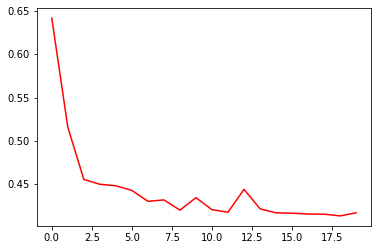

In [29]:
# define our loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# train the parameters
history = model.fit(X_train, y_train, epochs=20, batch_size=16)

# evaluate accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=16)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=16)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']

plt.plot(range(len(losses)), losses, 'r')
plt.show()

##### Modelo 2 de Red Neuronal
Se elije un segundo modelo de 6 capas, manteniendo una estructura similar de todas las capas oculas con función de activación relu y de salida en sigmoid.

- learning rate = 0.01
- Capa 1 = 'relu', 20 nodos
- Capa 2 = 'relu', 20 nodos
- Capa 3 = 'relu', 10 nodos
- Capa 4 = 'relu', 20 nodos
- Capa 5 = 'relu', 10 nodos
- Capa 6 = 'sigmoid'

In [30]:
model = models.Sequential()

# Capa 1
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu', input_dim=len(features)))
# Capa 2
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu'))
# Capa 3
model.add(Dense(10, kernel_initializer = 'uniform', activation='relu'))
# Capa 4
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu'))
# Capa 5
model.add(Dense(10, kernel_initializer = 'uniform', activation='relu'))
# Capa de Salida
model.add(Dense(1, kernel_initializer = 'uniform', activation='sigmoid'))

Epoch 1/20
39/39 [==============================] - 1s 3ms/step - loss: 0.6759 - accuracy: 0.5987
Epoch 2/20
39/39 [==============================] - 0s 2ms/step - loss: 0.5991 - accuracy: 0.6228
Epoch 3/20
39/39 [==============================] - 0s 3ms/step - loss: 0.5387 - accuracy: 0.7432
Epoch 4/20
39/39 [==============================] - 0s 2ms/step - loss: 0.5256 - accuracy: 0.7961
Epoch 5/20
39/39 [==============================] - 0s 2ms/step - loss: 0.5133 - accuracy: 0.8026
Epoch 6/20
39/39 [==============================] - 0s 2ms/step - loss: 0.4896 - accuracy: 0.8074
Epoch 7/20
39/39 [==============================] - 0s 2ms/step - loss: 0.4881 - accuracy: 0.8234
Epoch 8/20
39/39 [==============================] - 0s 2ms/step - loss: 0.4709 - accuracy: 0.8218
Epoch 9/20
39/39 [==============================] - 0s 2ms/step - loss: 0.4664 - accuracy: 0.8170
Epoch 10/20
39/39 [==============================] - 0s 2ms/step - loss: 0.4663 - accuracy: 0.8250
Epoch 11/20
39/39 [

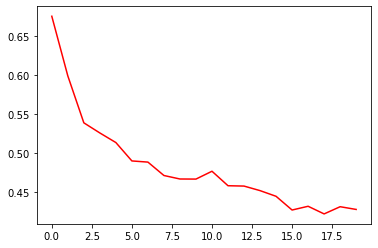

In [31]:
# define our loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# train the parameters
history = model.fit(X_train, y_train, epochs=20, batch_size=16)

# evaluate accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=16)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=16)[1]
#print('Training accuracy: %s' % train_acc)
#print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']

plt.plot(range(len(losses)), losses, 'r')
plt.show()

##### Modelo 3  de Red Neuronal
Se elije un modelo similar al modelo 2, con mismo numero de capas y nodos por capa. Sin embargo, se intercalan las funciones de activación entre relu y sigmoid.
- learning rate = 0.01
- Capa 1 = 'relu'
- Capa 2 = 'sigmoid'
- Capa 3 = 'relu'
- Capa 4 = 'sigmoid'
- Capa 5 = 'relu'
- Capa 6 = 'sigmoid'

In [32]:
model = models.Sequential()

# Capa 1
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu', input_dim=len(features)))
# Capa 2
model.add(Dense(20, kernel_initializer = 'uniform', activation='sigmoid'))
# Capa 3
model.add(Dense(10, kernel_initializer = 'uniform', activation='relu'))
# Capa 4
model.add(Dense(20, kernel_initializer = 'uniform', activation='sigmoid'))
# Capa 5
model.add(Dense(10, kernel_initializer = 'uniform', activation='relu'))
# Capa de Salida
model.add(Dense(1, kernel_initializer = 'uniform', activation='sigmoid'))

Epoch 1/20
39/39 [==============================] - 1s 2ms/step - loss: 0.6785 - accuracy: 0.6228
Epoch 2/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6671 - accuracy: 0.6228
Epoch 3/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6640 - accuracy: 0.6228
Epoch 4/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6633 - accuracy: 0.6228
Epoch 5/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.6228
Epoch 6/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.6228
Epoch 7/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.6228
Epoch 8/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6630 - accuracy: 0.6228
Epoch 9/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6628 - accuracy: 0.6228
Epoch 10/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.6228
Epoch 11/20
39/39 [

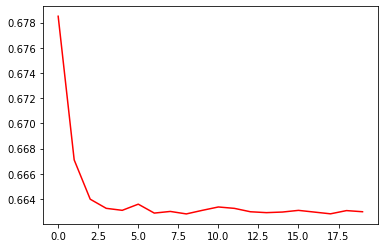

In [33]:
# define our loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# train the parameters
history = model.fit(X_train, y_train, epochs=20, batch_size=16)

# evaluate accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=16)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=16)[1]
#print('Training accuracy: %s' % train_acc)
#print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']

plt.plot(range(len(losses)), losses, 'r')
plt.show()

##### Modelo 4 de Red Neuronal
En el modelo 3 apreciamos que si bien se ajusta bien al modelo de prueba,se pierde exactitud con el set de validación, por lo cual se retoma el modelo 3 y se modifica el learning rate de 0.01 a 0.009, debido a que se aprecia una oscilación en cuanto a la pérdida, por lo cual s ebsca suavizar la curva.

- learning rate = 0.009
- Capa 1 = 'relu', 20 nodos
- Capa 2 = 'relu', 20 nodos
- Capa 3 = 'relu', 10 nodos
- Capa 4 = 'relu', 20 nodos
- Capa 5 = 'relu', 10 nodos
- Capa 6 = 'sigmoid'

In [34]:
model = models.Sequential()

# Capa 1
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu', input_dim=len(features)))
# Capa 2
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu'))
# Capa 3
model.add(Dense(10, kernel_initializer = 'uniform', activation='relu'))
# Capa 4
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu'))
# Capa 5
model.add(Dense(10, kernel_initializer = 'uniform', activation='relu'))
# Capa de Salida
model.add(Dense(1, kernel_initializer = 'uniform', activation='sigmoid'))

Epoch 1/20
39/39 [==============================] - 1s 2ms/step - loss: 0.6827 - accuracy: 0.6100
Epoch 2/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6689 - accuracy: 0.6228
Epoch 3/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6645 - accuracy: 0.6228
Epoch 4/20
39/39 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6228
Epoch 5/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.6228
Epoch 6/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.6228
Epoch 7/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.6228
Epoch 8/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.6228
Epoch 9/20
39/39 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.6228
Epoch 10/20
39/39 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6228
Epoch 11/20
39/39 [

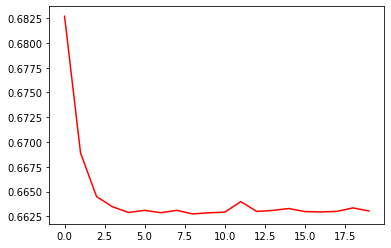

In [35]:
# define our loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.009), metrics=['accuracy'])

# train the parameters
history = model.fit(X_train, y_train, epochs=20, batch_size=16)

# evaluate accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=16)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=16)[1]
#print('Training accuracy: %s' % train_acc)
#print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']

plt.plot(range(len(losses)), losses, 'r')
plt.show()

##### Modelo 5 de Red Neuronal
Nuevamente se pierde accuracy respecto al ajuste con el set de entrenamiento y con el de validación, por lo cual se elije el segundo modelo de 6 capas, manteniendo una estructura similar de todas las capas oculas con función de activación relu y de salida en sigmoid, sin embargo, se modifica la cantidad de nodos de la capa 3 aumentandola a 20.

- learning rate = 0.01
- Capa 1 = 'relu', 20 nodos
- Capa 2 = 'relu', 20 nodos
- Capa 3 = 'relu', 20 nodos
- Capa 4 = 'relu', 20 nodos
- Capa 5 = 'relu', 10 nodos
- Capa 6 = 'sigmoid'

In [36]:
model = models.Sequential()

# Capa 1
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu', input_dim=len(features)))
# Capa 2
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu'))
# Capa 3
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu'))
# Capa 4
model.add(Dense(20, kernel_initializer = 'uniform', activation='relu'))
# Capa 5
model.add(Dense(10, kernel_initializer = 'uniform', activation='relu'))
# Capa de Salida
model.add(Dense(1, kernel_initializer = 'uniform', activation='sigmoid'))

Epoch 1/20
39/39 [==============================] - 1s 2ms/step - loss: 0.6622 - accuracy: 0.6180
Epoch 2/20
39/39 [==============================] - 0s 2ms/step - loss: 0.5496 - accuracy: 0.6469
Epoch 3/20
39/39 [==============================] - 0s 1ms/step - loss: 0.5298 - accuracy: 0.7945
Epoch 4/20
39/39 [==============================] - 0s 2ms/step - loss: 0.5142 - accuracy: 0.7929
Epoch 5/20
39/39 [==============================] - 0s 2ms/step - loss: 0.5021 - accuracy: 0.8026
Epoch 6/20
39/39 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.8138
Epoch 7/20
39/39 [==============================] - 0s 2ms/step - loss: 0.4824 - accuracy: 0.8090
Epoch 8/20
39/39 [==============================] - 0s 2ms/step - loss: 0.4679 - accuracy: 0.8218
Epoch 9/20
39/39 [==============================] - 0s 2ms/step - loss: 0.4724 - accuracy: 0.8122
Epoch 10/20
39/39 [==============================] - 0s 2ms/step - loss: 0.5117 - accuracy: 0.7881
Epoch 11/20
39/39 [

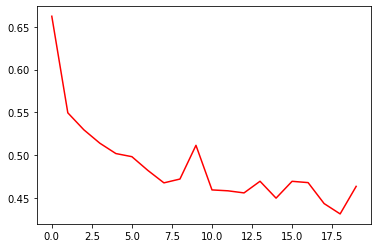

In [37]:
# define our loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# train the parameters
history = model.fit(X_train, y_train, epochs=20, batch_size=16)

# evaluate accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=16)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=16)[1]
#print('Training accuracy: %s' % train_acc)
#print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']

plt.plot(range(len(losses)), losses, 'r')
plt.show()

### 2.3.- Modelo 2 Mejor Accuracy

En definitiva, el "Modelo 2" con un accuracy del 77% para el subconjunto de datos de validación, es el que se comporta de mejor manera.